# 门控循环单元（GRU）

### 重置门和更新门
* 重置门有助于捕获序列中的短期依赖关系。
* 更新门有助于捕获序列中的长期依赖关系。
$$
\begin{aligned}
重置门:\mathbf{R}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xr} + \mathbf{H}_{t-1} \mathbf{W}_{hr} + \mathbf{b}_r),\\
更新门:\mathbf{Z}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xz} + \mathbf{H}_{t-1} \mathbf{W}_{hz} + \mathbf{b}_z),
\end{aligned}
$$

其中$\mathbf{W}_{xr}, \mathbf{W}_{xz} \in \mathbb{R}^{d \times h}$
和$\mathbf{W}_{hr}, \mathbf{W}_{hz} \in \mathbb{R}^{h \times h}$是权重参数，
$\mathbf{b}_r, \mathbf{b}_z \in \mathbb{R}^{1 \times h}$是偏置参数。
请注意，在求和过程中会触发广播机制

### 候选隐状态

接下来，让我们将重置门$\mathbf{R}_t$
中的常规隐状态更新机制集成，
得到在时间步$t$的*候选隐状态*（candidate hidden state）
$\tilde{\mathbf{H}}_t \in \mathbb{R}^{n \times h}$。

$$\tilde{\mathbf{H}}_t = \tanh(\mathbf{X}_t \mathbf{W}_{xh} + \left(\mathbf{R}_t \odot \mathbf{H}_{t-1}\right) \mathbf{W}_{hh} + \mathbf{b}_h),$$


其中$\mathbf{W}_{xh} \in \mathbb{R}^{d \times h}$
和$\mathbf{W}_{hh} \in \mathbb{R}^{h \times h}$是权重参数，
$\mathbf{b}_h \in \mathbb{R}^{1 \times h}$是偏置项，
符号$\odot$是Hadamard积（按元素乘积）运算符。
在这里，我们使用tanh非线性激活函数来确保候选隐状态中的值保持在区间$(-1, 1)$中。


### 隐状态

上述的计算结果只是候选隐状态，我们仍然需要结合更新门$\mathbf{Z}_t$的效果。
这一步确定新的隐状态$\mathbf{H}_t \in \mathbb{R}^{n \times h}$
在多大程度上来自旧的状态$\mathbf{H}_{t-1}$和
新的候选状态$\tilde{\mathbf{H}}_t$。
更新门$\mathbf{Z}_t$仅需要在
$\mathbf{H}_{t-1}$和$\tilde{\mathbf{H}}_t$
之间进行按元素的凸组合就可以实现这个目标。
这就得出了门控循环单元的最终更新公式：

$$\mathbf{H}_t = \mathbf{Z}_t \odot \mathbf{H}_{t-1}  + (1 - \mathbf{Z}_t) \odot \tilde{\mathbf{H}}_t.$$

每当更新门$\mathbf{Z}_t$接近$1$时，模型就倾向只保留旧状态。
此时，来自$\mathbf{X}_t$的信息基本上被忽略，
从而有效地跳过了依赖链条中的时间步$t$。
相反，当$\mathbf{Z}_t$接近$0$时，
新的隐状态$\mathbf{H}_t$就会接近候选隐状态$\tilde{\mathbf{H}}_t$。
这些设计可以帮助我们处理循环神经网络中的梯度消失问题，
并更好地捕获时间步距离很长的序列的依赖关系。
例如，如果整个子序列的所有时间步的更新门都接近于$1$，
则无论序列的长度如何，在序列起始时间步的旧隐状态都将很容易保留并传递到序列结束。




In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import math
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

### [**初始化模型参数**]

下一步是初始化模型参数。
我们从标准差为$0.01$的高斯分布中提取权重，
并将偏置项设为$0$，超参数`num_hiddens`定义隐藏单元的数量，
实例化与更新门、重置门、候选隐状态和输出层相关的所有权重和偏置。


In [2]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xz, W_hz, b_z = three()  # 更新门参数
    W_xr, W_hr, b_r = three()  # 重置门参数
    W_xh, W_hh, b_h = three()  # 候选隐状态参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [3]:
class RNNModelScratch: #@save
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [4]:
class RNNModel(nn.Module):
    """循环神经网络模型"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # 如果RNN是双向的（之后将介绍），num_directions应该是2，否则应该是1
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 它的输出形状是(时间步数*批量大小,词表大小)。
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

### 定义模型

现在我们将[**定义隐状态的初始化函数**]`init_gru_state`。
与 :numref:`sec_rnn_scratch`中定义的`init_rnn_state`函数一样，
此函数返回一个形状为（批量大小，隐藏单元个数）的张量，张量的值全部为零。


In [5]:
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

现在我们准备[**定义门控循环单元模型**]，
模型的架构与基本的循环神经网络单元是相同的，
只是权重更新公式更为复杂。


In [6]:
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # print(inputs.shape) [35, 32, 28]
    for X in inputs:  # batch_size, num_steps = 32, 35
        # print(X.shape) [32, 28]
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        # print(Z.shape) [32, 256]
        # print(R.shape) [32, 256]
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        # print( H_tilda.shape ) [32, 256]
        H = Z * H + (1 - Z) * H_tilda
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

### [**训练**]与预测

训练和预测的工作方式与 :numref:`sec_rnn_scratch`完全相同。
训练结束后，我们分别打印输出训练集的困惑度，
以及前缀“time traveler”和“traveler”的预测序列上的困惑度。


perplexity 1.1, 43697.5 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


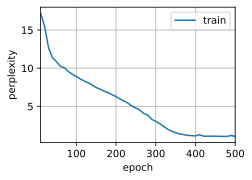

In [7]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                            init_gru_state, gru)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## [**简洁实现**]

高级API包含了前文介绍的所有配置细节，
所以我们可以直接实例化门控循环单元模型。
这段代码的运行速度要快得多，
因为它使用的是编译好的运算符而不是Python来处理之前阐述的许多细节。


perplexity 1.0, 319919.7 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


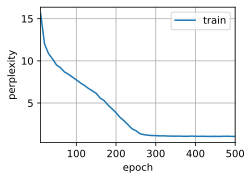

In [8]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = RNNModel(gru_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)